Model selection for GDP model failure analysis. In this notebook, we tune hyperparameters to predict GDP growth.

In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.neighbors import KernelDensity

from datetime import datetime

In [2]:
def gen_lags(X, n_lags):
    X_lagged = None
    for i in range(1, n_lags+1):
        l = X.shift(i).add_prefix('l%i.' % i)
        if X_lagged is None:
            X_lagged = l
        else:
            X_lagged = pd.concat((X_lagged, l), axis=1)
    return X_lagged

gdp = pd.read_csv('GDP-growth.csv')
X, y = gdp.drop('GDP_g', axis=1), gdp['GDP_g']
X, date = X.drop('date', axis=1), pd.to_datetime(X['date'])
X_lagged = gen_lags(X, 5)

In [3]:
train_idx = date < datetime(2007, 1, 1)
test_idx = ~train_idx & (date < datetime(2011, 1, 1))
X_train, X_test, y_train, y_test = (
    X_lagged[train_idx], X_lagged[test_idx],
    y[train_idx], y[test_idx]
)

In [4]:
from sklearn.neighbors import KNeighborsRegressor as KNeighborsRegressorMixin

class KNeighborsRegressor(KNeighborsRegressorMixin):
    def __init__(self, n_neighbors=5, n_components=1, n_lags=1):
        super().__init__(n_neighbors)
        self.n_components = n_components
        self.n_lags = n_lags
        
    def fit(self, X, y):
        X, y = self.select_lags(X, y)
        self.pca = PCA(n_components=self.n_components)
        X = self.pca.fit_transform(X)
        return super().fit(X, y)
    
    def predict(self, X):
        X = self.select_lags(X)
        X = self.pca.transform(X)
        return super().predict(X)
    
    def select_lags(self, X, y=None):
        X = X[[
            col 
            for i in range(1,self.n_lags+1) 
            for col in X.columns if col.startswith('l%i.' % i)
        ]]
        X = X.dropna()
        if y is None:
            return X
        return X, y.iloc[len(y)-len(X):]

In [5]:
params = {
    'n_neighbors': list(range(2,8)),
    'n_components': list(range(1,11)),
    'n_lags': list(range(1,5)),
}

cv = TimeSeriesSplit(n_splits=2)
grid = GridSearchCV(KNeighborsRegressor(), params, cv=cv)
reg = grid.fit(X_train, y_train).best_estimator_
print(grid.best_score_)
print(grid.best_params_)

0.2608948591820992
{'n_components': 5, 'n_lags': 1, 'n_neighbors': 4}


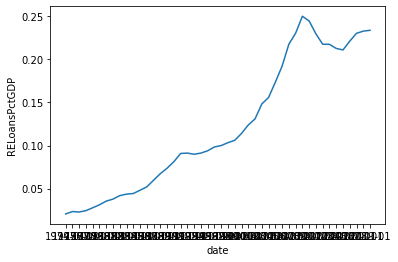

In [6]:
sns.lineplot('date','RELoansPctGDP',data=gdp)

In [ ]:
params = {
    'bandwidth': np.logspace(-1,1,20),
    'kernel': ('gaussian','tophat', 'epanechnikov', 'exponential','linear', 'cosine')
}
grid = GridSearchCV(KernelDensity(), params, cv=4)

def tune_kde(y):
    y = y.values.reshape(y.shape[0], 1)
    print(grid.fit(y).best_params_)

tune_kde(y_train[reg.n_lags:])
tune_kde(y_test)